In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv("hf://datasets/h1alexbel/sr-numerical/preprocessed/numerical.csv")

In [3]:
df.head()

,repo,releases,contributors,pulls,commits,issues,branches,workflows
0,openai/openai-cookbook,0,1142,743,859,35,23,2
1,immich-app/immich,189,490,4497,4603,423,69,15
2,The-Run-Philosophy-Organization/run,0,81,218,1290,39,4,1
3,geekan/HowToLiveLonger,0,10,25,76,27,2,1
4,AykutSarac/jsoncrack.com,20,28,135,1513,37,1,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   repo          4456 non-null   object
 1   releases      4456 non-null   int64 
 2   contributors  4456 non-null   int64 
 3   pulls         4456 non-null   int64 
 4   commits       4456 non-null   int64 
 5   issues        4456 non-null   int64 
 6   branches      4456 non-null   int64 
 7   workflows     4456 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 278.6+ KB


In [5]:
df.drop(columns=['repo'], inplace=True)

In [6]:
df.isna().sum()

releases        0
contributors    0
pulls           0
commits         0
issues          0
branches        0
workflows       0
dtype: int64

In [7]:
df.describe()

,releases,contributors,pulls,commits,issues,branches,workflows
count,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000,4456.000000
mean,22.419210,85.030296,250.684022,1092.295108,58.049372,19.837074,2.040619
std,69.664012,646.426924,1294.449893,9400.817093,270.854441,105.616499,4.440343
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,4.000000,9.000000,70.000000,5.000000,1.000000,0.000000
50%,1.000000,11.000000,34.000000,204.000000,19.000000,3.000000,1.000000
75%,18.000000,30.000000,163.000000,658.000000,54.000000,8.000000,2.000000
max,1000.000000,10000.000000,66369.000000,462583.000000,14526.000000,4521.000000,116.000000


# Пускай таргетом будет число коммитов - commits

## Отчистка от выбросов

In [8]:
def iqr_outliers_clear(df):
    len_before = len(df)
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_no_outliers = df[~((df < lower) | (df > upper)).any(axis=1)]
    print(f'Cтрок с выбросами {len_before - len(df_no_outliers)}')
    df = df.clip(lower=lower, upper=upper, axis=1) 
    return df

In [9]:
df_iqr = iqr_outliers_clear(df)

Cтрок с выбросами 1573


In [10]:
def zscore_outliers_clear(df):
    len_before = len(df)
    outliers_mask = (np.abs(stats.zscore(df)) > 3 ).any(axis=1)
    df = df[~outliers_mask]
    print(f'Отичистили строк с выбросами {len_before - len(df)}')
    return df


In [11]:
df_zscore = zscore_outliers_clear(df)

Отичистили строк с выбросами 214


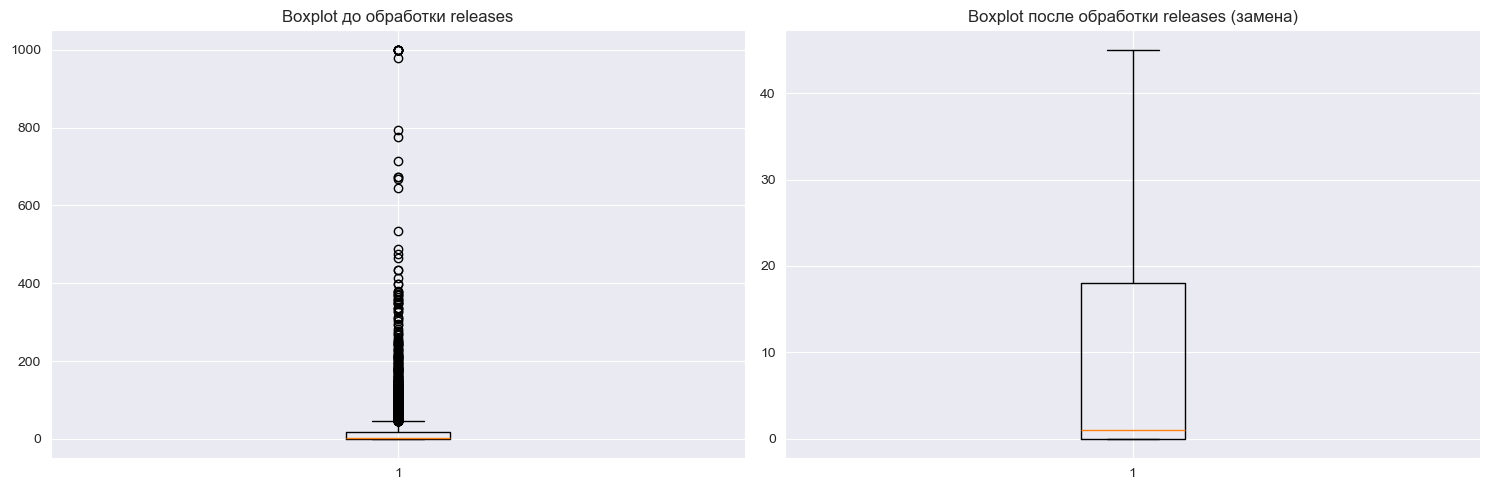

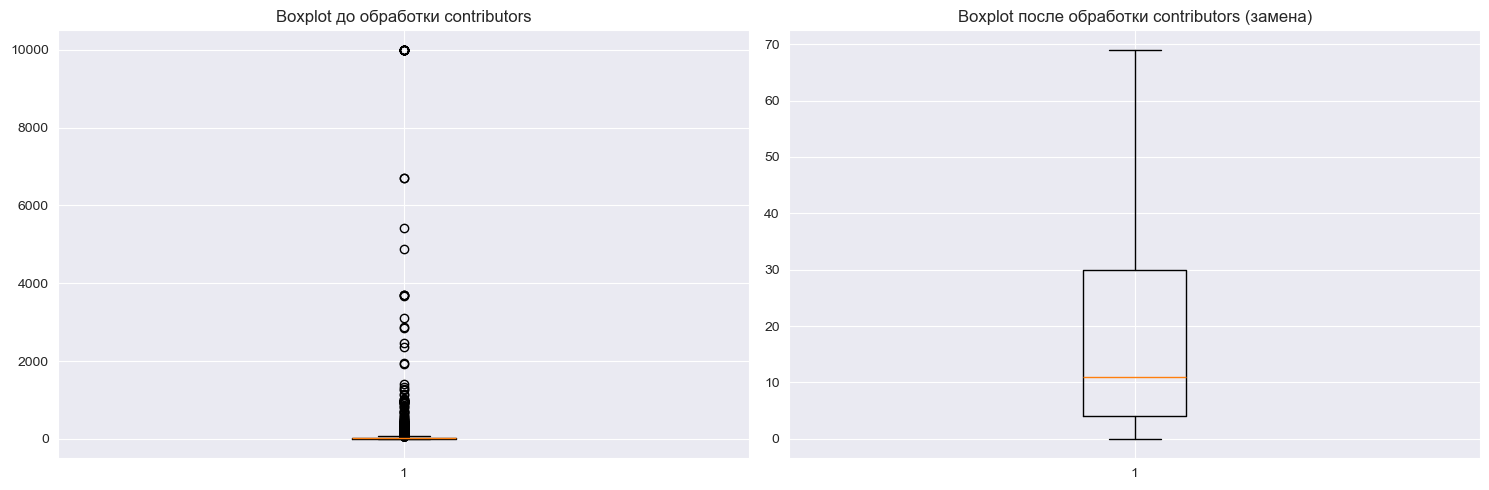

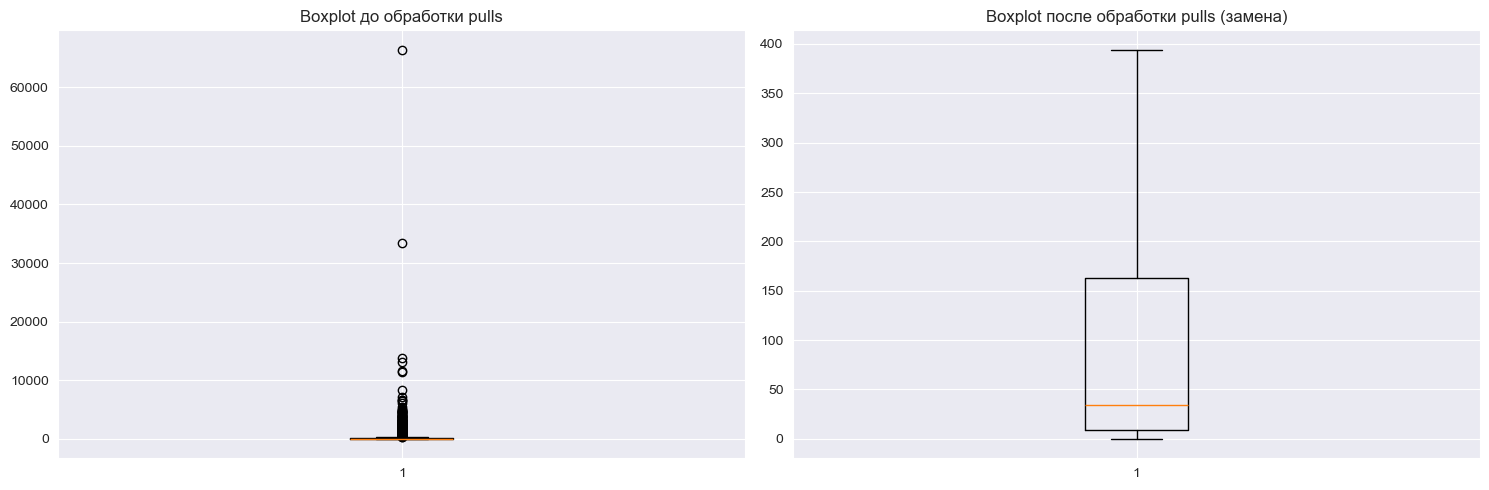

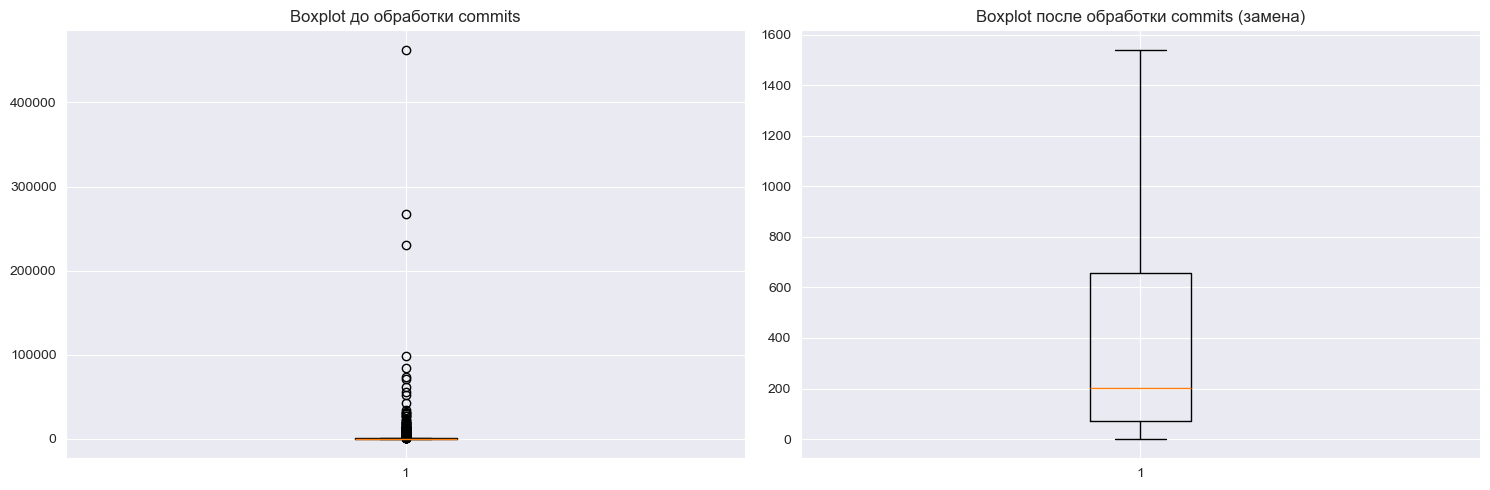

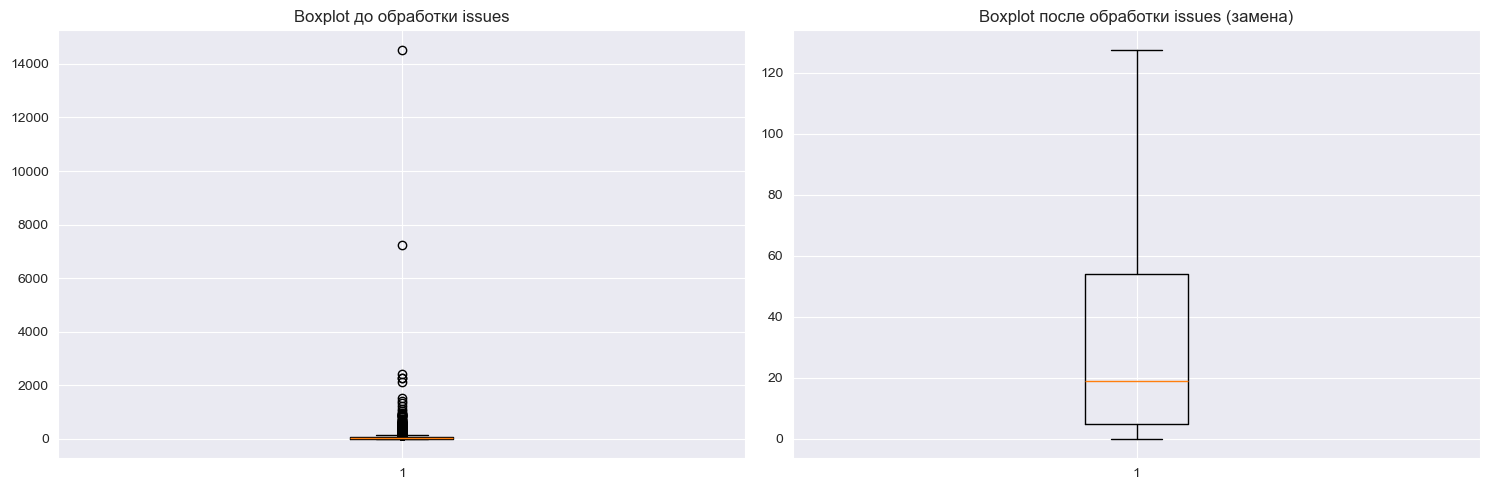

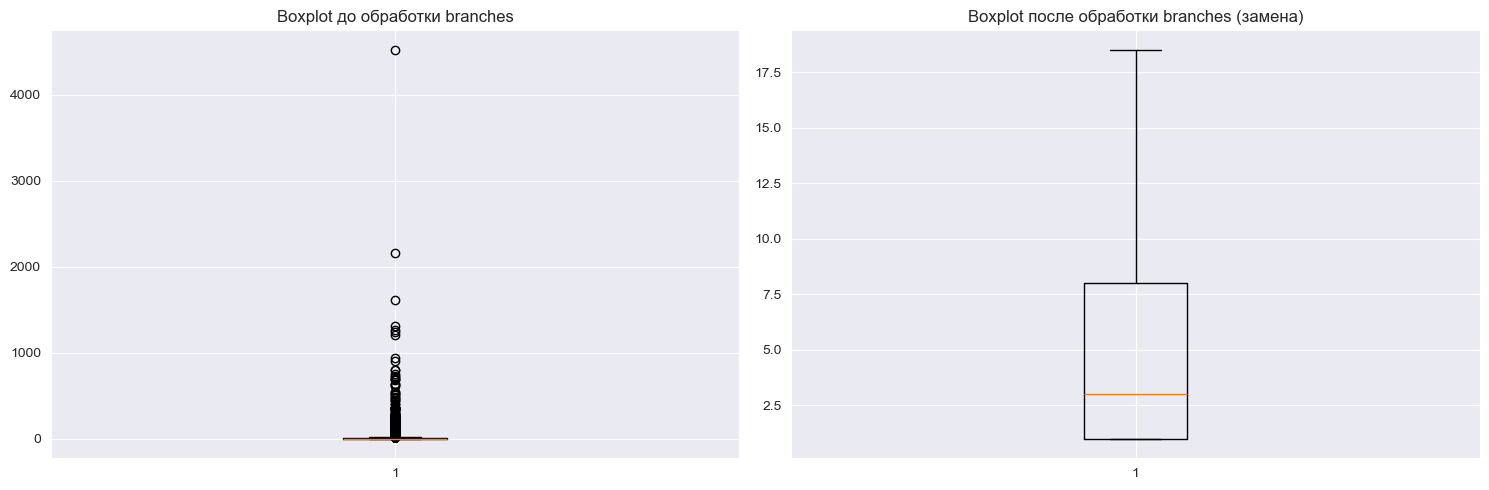

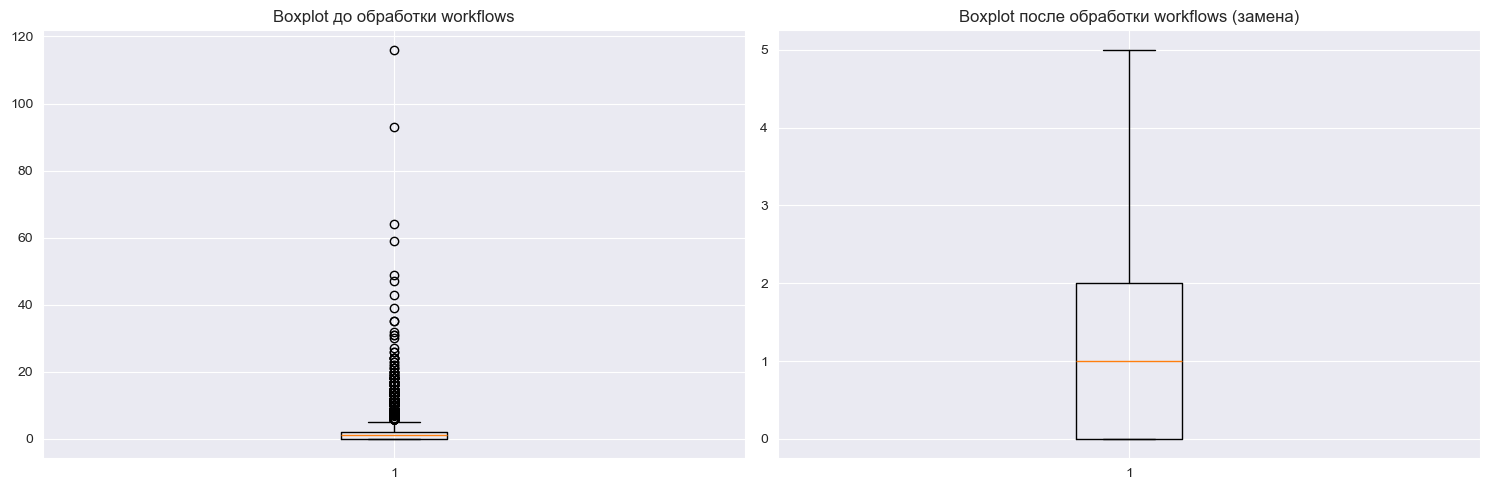

In [12]:
for col in df_iqr:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.boxplot(df[col])
    ax1.set_title(f'Boxplot до обработки {col}')
    
    ax2.boxplot(df_iqr[col])
    ax2.set_title(f'Boxplot после обработки {col} (замена)')
    
    plt.tight_layout()
    plt.show()

## Отбор признаков

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
clf = LinearRegression()
clf.fit(df_iqr.drop(columns=['commits']), df_iqr['commits'])

LinearRegression()

In [15]:
print(df_iqr.drop(columns=['commits']).columns)
clf.coef_ # Видим, что коэффициент при issue близок к нулю, уберем данный признак

Index(['releases', 'contributors', 'pulls', 'issues', 'branches', 'workflows'], dtype='object')


array([ 5.06440417,  3.01758395,  1.55064456,  0.60898066,  5.02648401,
       21.41737798])

In [16]:
df_iqr = df_iqr.drop(columns=['issues'])